In [ ]:
# Importing necessary libraries
from matplotlib import legend
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import os
import numpy as np
from icecream import ic
from tqdm import tqdm
from itertools import chain
from get_data import get_data
import logging
import os

In [ ]:
 #Define the LSTM model with two hidden layers
torch.set_default_dtype(torch.float64)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)
class LSTMmodel(nn.Module):
    """
    LSTM model class for derivative estimation.
    """

    def __init__(self, input_size, hidden_size, out_size, layers):
        """
        Initialize the LSTM model.

        Args:
        - input_size: Size of input
        - hidden_size: Size of hidden layer
        - out_size: Size of output
        - layers: Number of layers
        """
        super().__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size

        # Define LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=layers, batch_first=True)

        # Define linear layer
        self.linear = nn.Linear(hidden_size, out_size)

    def forward(self, seq):
        """
        Forward pass through the LSTM model.

        Args:
        - seq: Input sequence

        Returns:
        - pred: Model prediction
        - hidden: Hidden state
        """
        lstm_out, hidden = self.lstm(seq)
        pred = self.linear(lstm_out)

        return pred, hidden


class GRUmodel(nn.Module):
    """
    LSTM model class for derivative estimation.
    """

    def __init__(self, input_size, hidden_size, out_size, layers):
        """
        Initialize the LSTM model.

        Args:
        - input_size: Size of input
        - hidden_size: Size of hidden layer
        - out_size: Size of output
        - layers: Number of layers
        """
        super().__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size

        # Define LSTM layer
        self.lstm = nn.GRU(input_size, hidden_size, num_layers=layers, batch_first=True)

        # Define linear layer
        self.linear = nn.Linear(hidden_size, out_size)

    def forward(self, seq):
        """
        Forward pass through the LSTM model.

        Args:
        - seq: Input sequence

        Returns:
        - pred: Model prediction
        - hidden: Hidden state
        """
        lstm_out, hidden = self.lstm(seq)
        pred = self.linear(lstm_out)

        return pred, hidden


def test(test_data, model, steps=600, ws=10, plot_opt=False):

    #test_data = test_dataloader.get_all_data() 
    model.eval()
    loss_fn = nn.MSELoss()
    test_loss = 0
    test_loss_deriv = 0
    loss_list=[]
    randoms = np.random.randint(0,100,10)
    plotted=0
    for i, x in enumerate(test_data):
        x=x.to(device)
        if i not in randoms:
            continue

        with torch.inference_mode():

            pred = torch.zeros((steps, 3), device=device)
            pred_next_step = torch.zeros((steps, 3), device=device)

            if ws > 1:
                pred[0:ws, :] = x[0:ws, :]
                pred[:, 0] = x[:, 0]
                pred_next_step[0:ws, :] = x[0:ws, :]
                pred_next_step[:, 0] = x[:, 0]
            else:
                pred[0, :] = x[0, :]
                pred[:, 0] = x[:, 0]
                pred_next_step[0, :] = x[0, :]
                pred_next_step[:, 0] = x[:, 0]

            for i in range(len(x) - ws):

                out, _ = model(pred[i:i+ws, :])
                pred[i+ws, 1:] = pred[i+ws-1, 1:] + out[-1, :]
                pred_next_step[i+ws, 1:] = x[i+ws-1, 1:] + out[-1, :]
            
            loss_list.append((loss_fn(pred[:, 1], x[:, 1]).detach().cpu().numpy(),loss_fn(pred[:, 2], x[:, 2]).detach().cpu().numpy()))
            test_loss += loss_fn(pred[:, 1], x[:, 1]).detach().cpu().numpy()
            test_loss_deriv += loss_fn(pred[:, 2], x[:, 2]).detach().cpu().numpy()

            if plot_opt and plotted==0:
                plotted=1
                figure , axs = plt.subplots(1,3,figsize=(16,9))
            
                axs[0].plot(pred.detach().cpu().numpy()[:, 1], color="red", label="pred")
                axs[0].plot(pred_next_step.detach().cpu().numpy()[:, 1], color="green", label="next step from data")
                axs[0].plot(x.detach().cpu().numpy()[:, 1], color="blue", label="true", linestyle="dashed")
                axs[0].set_title("position")
                axs[0].grid()
                axs[0].legend()

                axs[1].plot(pred.detach().cpu().numpy()[:, 2], color="red", label="pred")
                axs[1].plot(pred_next_step.detach().cpu().numpy()[:, 2], color="green", label="next step from data")
                axs[1].plot(x.detach().cpu().numpy()[:, 2], color="blue", label="true", linestyle="dashed")
                axs[1].set_title("speed")
                axs[1].grid()
                axs[1].legend()

                axs[2].plot(x.detach().cpu().numpy()[:,0], label="pressure")
                axs[2].set_title("pressure")
                axs[2].grid()
                axs[2].legend()

                plt.grid()
                plt.legend()
                plt.show()
            
    return np.mean(test_loss), np.mean(test_loss_deriv), loss_list



In [ ]:
def get_data(path = "ventil_lstm\save_data_test.csv", timesteps_from_data=100, skip_steps_start = 1, skip_steps_end = 1, drop_half_timesteps = True, normalise_s_w=False, rescale_p=False, num_inits=0):
    
    if timesteps_from_data>1:
     df = pd.read_csv(path, header=0, nrows=timesteps_from_data, skiprows=skip_steps_start)
    else:
     df = pd.read_csv(path, header=0, skiprows=skip_steps_start)

    if skip_steps_end>1:
       df = df.iloc[0:len(df)-skip_steps_end]

    #drop even more timesteps
    if drop_half_timesteps:
     df = df.iloc[::2]

    if num_inits>1:
       df = df.iloc[:,0:4*num_inits]
    #Reorder columns for familiar setup (t,u,x) here (t, p_b, s_b, w_b)
    L = df.columns.to_list()
    time_cols = L[0::4]
    sb_cols = L[1::4]
    pb_cols = L[2::4]
    wb_cols = L[3::4]
    new_col_order = [x for sub in list(zip(time_cols, pb_cols, sb_cols, wb_cols)) for x in sub]
    df= df[new_col_order]
    df = df.drop(time_cols, axis=1)

    #normalise each column of the dataframe
    #mean normalization
    #df=(df-df.mean())/df.std()
    
    #Can't normalize p_b because then a[i]*X+b[i] becomes cX+d for all i.. same with mean normal. 
    
    # Normalise / Rescale
    if normalise_s_w:
        tmp=pb_cols+sb_cols+wb_cols
        df[tmp]=(df[tmp]-df[tmp].min())/(df[tmp].max()-df[tmp].min())
    if rescale_p:
        df[pb_cols] = df[pb_cols] / 1e5

    tensor = torch.tensor(df.values)

    #tensor with t=0:600, 500 different input and the 3 outputs [s_b, p_b, w_b]
    a = num_inits if num_inits>0 else 500
    a=int(len(df.columns.to_list())/3)

    tensor = tensor.view(len(df),a,3).permute(1,0,2)

    return tensor


In [ ]:
input_data = get_data(path = "save_data_test3.csv", 
                                timesteps_from_data=0, 
                                skip_steps_start = 100,
                                skip_steps_end = 0, 
                                drop_half_timesteps = True,
                                normalise_s_w=True,
                                rescale_p=False,
                                num_inits=0)

input_data=input_data.to(device)
# Split data into train and test sets
train_size = int(0.7 * len(input_data))
test_size = len(input_data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(input_data, [train_size, test_size])

# Take a slice of data for training (only slice_of_data many timesteps)
slice_of_data = 300

#train_dataset = train_dataset[:][:, 0:slice_of_data, :]


window_size = 4
h_size=64
l_num=3
model = LSTMmodel(input_size=3, hidden_size=h_size, out_size=2, layers=l_num).to(device)

path = f"Ventil_trained_NNs\lstm_ws{window_size}hs{h_size}layer{l_num}_nummer329.pth"

model.load_state_dict(torch.load(path, map_location=torch.device(device)))

a, b, loss_list= test(input_data, model, steps=input_data.size(dim=1), ws=window_size, plot_opt=True)
print(loss_list)

In [ ]:
from matplotlib import legend
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import os
import numpy as np
from icecream import ic
from tqdm import tqdm
from itertools import chain
from get_data import get_data
import logging
import os
import cProfile
import pstats
from dataloader import *


losses = []

# Generate input data
input_data = get_data(path = "save_data_test3.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = True,
                        normalise_s_w=True,
                        rescale_p=False,
                        num_inits=40)



data  = CustomDataset(input_data, window_size=4)

#Split data into train and test sets
train_size = int(0.7 * len(data) / 64) * 64
test_size = len(data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=64,pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=64)

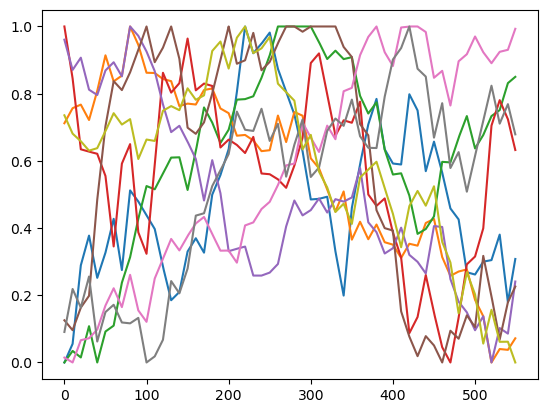

In [21]:
for x in train_data:
    plt.plot(x[:,0].numpy())
plt.show()

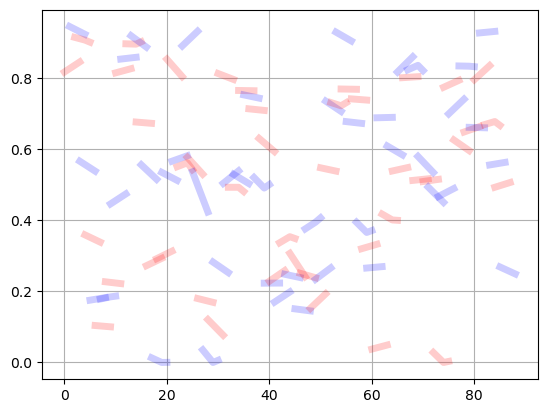

In [77]:
ws=4

train_inits = np.random.randint(0,len(input_data), 10)
train_inits = np.unique(train_inits)
test_inits = np.array([x for x in range(len(input_data)) if x not in train_inits])

train_data = input_data[train_inits,:,:]
test_data = input_data[test_inits,:,:]

data_set  = CustomDataset(train_data, window_size=4)

train_dataloader = DataLoader(data_set, batch_size=64,pin_memory=True)

time = np.linspace(0,input_data.size(dim=1)*len(input_data),input_data.size(dim=1)*len(input_data))


for i, (inp, label) in enumerate(train_dataloader):
    if i%2==0:
     plt.plot(time[i:i+ws], inp[0,:,0].numpy(), linewidth=5, alpha=0.2, color="red")
     #plt.scatter(time[i:i+ws], label[0,:,0].numpy(), linewidth=5, alpha=0.3, color="red")
     
    else:
     plt.plot(time[i:i+ws], inp[0,:,0].numpy(), linewidth=5, alpha=0.2, color="blue")

plt.grid()
plt.show()


In [76]:


num_of_inits_train = 500
percentage = 0.9

train_inits = np.random.randint(0,num_of_inits_train, num_of_inits_train)
train_inits = np.unique(train_inits)
test_inits = np.array([x for x in range(num_of_inits_train) if x not in train_inits])

print(len(train_inits), len(test_inits))

ic(train_inits, test_inits)
if percentage < 0.99:
    while len(train_inits) < num_of_inits_train * percentage:
        i = np.random.randint(0,len(test_inits),1)[0]
        train_inits = np.append(train_inits,test_inits[i])
        test_inits = np.delete(test_inits, i)

ic( train_inits)

ic(test_inits)    




SyntaxError: expected ':' (4125336195.py, line 11)